# Grab Sentinel-1 imagery and generate Analysis Ready Data (ARD) using the workflow from Mulissa et al. (2021)

Rainey Aberle 

2022

In [1]:
import ee
import matplotlib.pyplot as plt
import wxee as wx
import sys
import geopandas as gpd
import glob
import numpy as np

In [2]:
site_name = 'SouthCascade'

# -----Define paths in directory
# base directory (path to planet-snow/)
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to gee_s1_ard/python-api/
ard_path = base_path + '../gee_s1_ard/python-api/'
# output folder for best classifier
out_path = base_path + 'inputs-outputs/'
# path to classified points used to train and test classifiers
data_pts_path = base_path + '../classified-points/'
# path to AOI shapefiles
AOI_fn = base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'

# -----Define search filters
date_start = '2021-05-01'
date_end = '2021-11-01'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils_PlanetScope as pf

# -----Add path to functions
sys.path.insert(1, ard_path)
import wrapper as w

In [3]:
# -----Load AOI as gpd.GeoDataFrame
AOI_fn = glob.glob(AOI_fn)[0]
AOI = gpd.read_file(AOI_fn)

# -----Reformat for GEE querying
# reproject AOI to WGS 84 for compatibility with DEM
AOI_WGS = AOI.to_crs(4326)
# reformat AOI_WGS bounding box as ee.Geometry for clipping DEM
AOI_WGS_bb_ee = ee.Geometry.Polygon(
                        [[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                          [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                          [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                          [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                          [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]]
                        ]).buffer(2000)  

# -----Solve for optimal UTM zone for reprojection
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
epsg_UTM = pf.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])

In [4]:
# Define dictionary of parameters
params = {'APPLY_BORDER_NOISE_CORRECTION': True,
          'APPLY_TERRAIN_FLATTENING': True,
          'APPLY_SPECKLE_FILTERING': True, 
          'POLARIZATION': 'VVVH',
          'PLATFORM_NUMBER': None,
          'ORBIT': None, 
          'ORBIT_NUM': None, 
          'SPECKLE_FILTER_FRAMEWORK': 'MULTI',
          'SPECKLE_FILTER': 'LEE',
          'SPECKLE_FILTER_KERNEL_SIZE': 9,
          'SPECKLE_FILTER_NR_OF_IMAGES': 10,
          'APPLY_TERRAIN_FLATTENING': True,
          'DEM': ee.Image('USGS/SRTMGL1_003'), # ee.Image("NASA/ASTER_GED/AG100_003"),
          'TERRAIN_FLATTENING_MODEL': 'VOLUME',
          'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
          'FORMAT' : 'DB',
          'CLIP_TO_ROI': True,
          'SAVE_ASSET': False,
          'ASSET_ID': None,
          'START_DATE': date_start,
          'STOP_DATE': date_end,
          'ROI': AOI_WGS_bb_ee
         }

# run the gee_s1_ard wrapper
S1 = w.s1_preproc(params)

Number of images in collection:  47
Additional border noise correction is completed
Multi-temporal speckle filtering is completed
Radiometric terrain normalization is completed


In [5]:
# Convert ee.ImageCollection to xarray.Dataset
S1_ds = S1.wx.to_xarray(scale=10, crs='EPSG:4326')

# reproject to UTM
S1_ds = S1_ds.rio.reproject('EPSG:'+epsg_UTM)

Requesting data:   0%|          | 0/47 [00:00<?, ?it/s]

Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


In [6]:
# set no data values to NaN
S1_ds = S1_ds.where(S1_ds!=S1_ds.nodatavals[0])


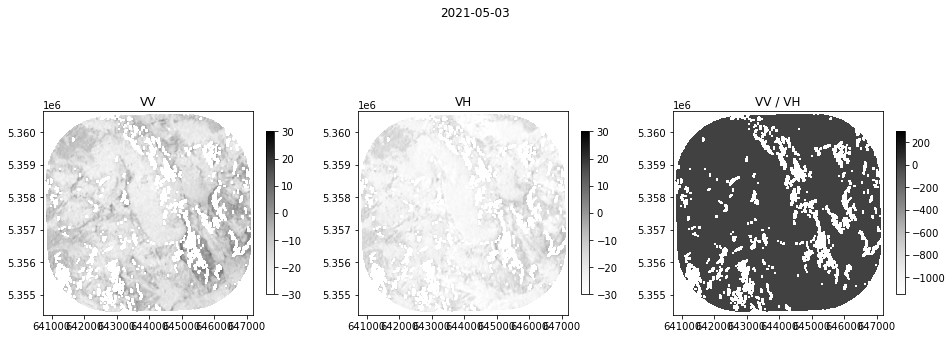

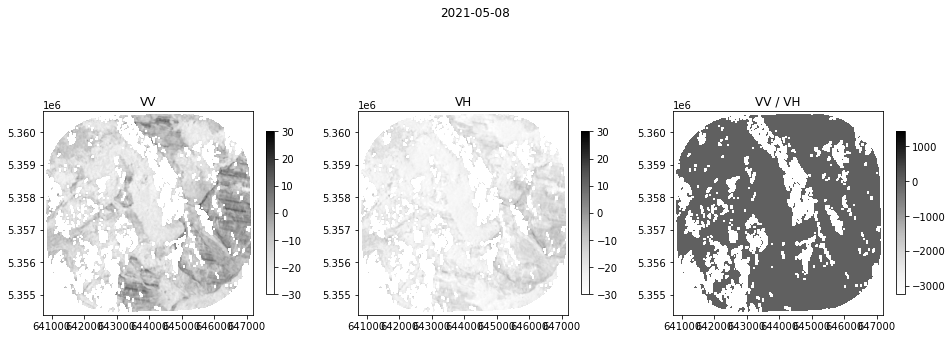

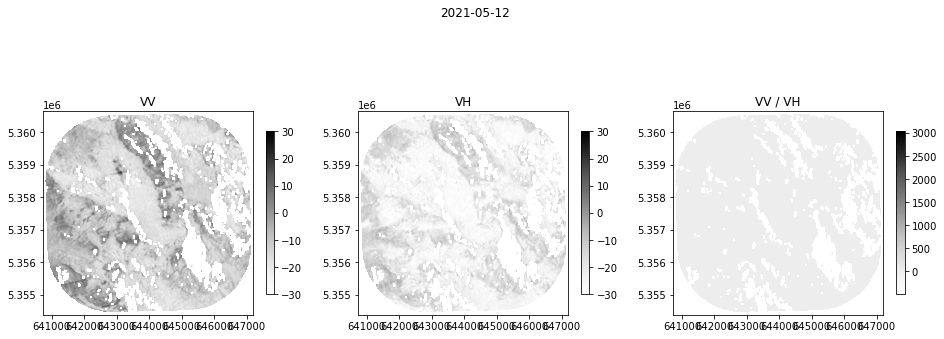

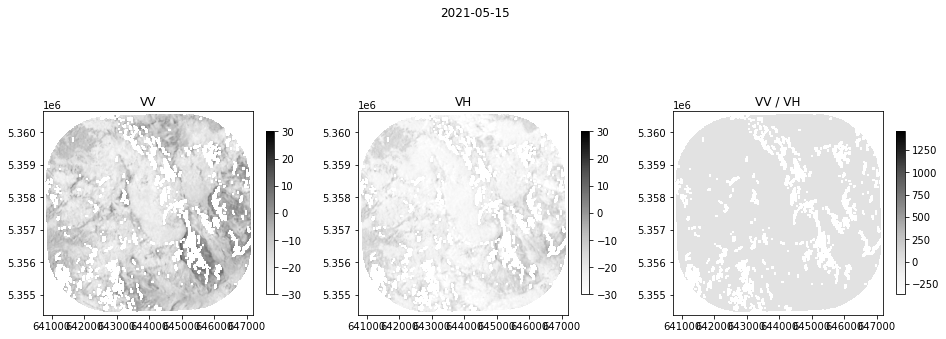

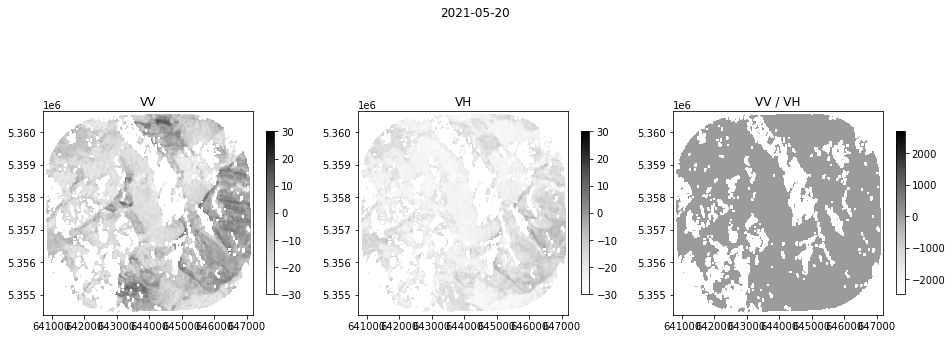

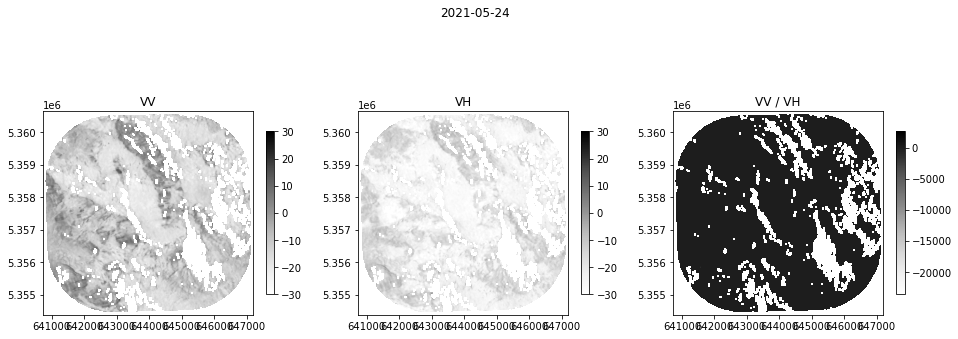

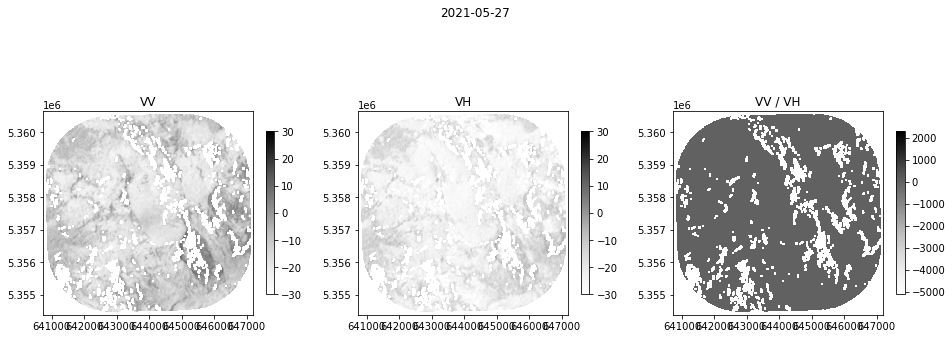

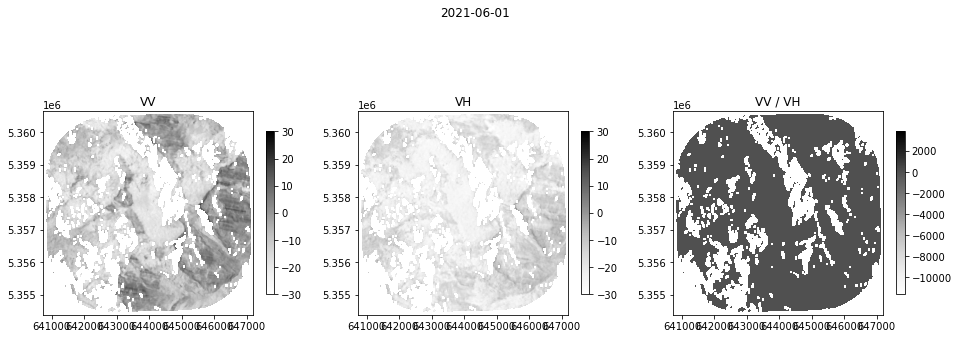

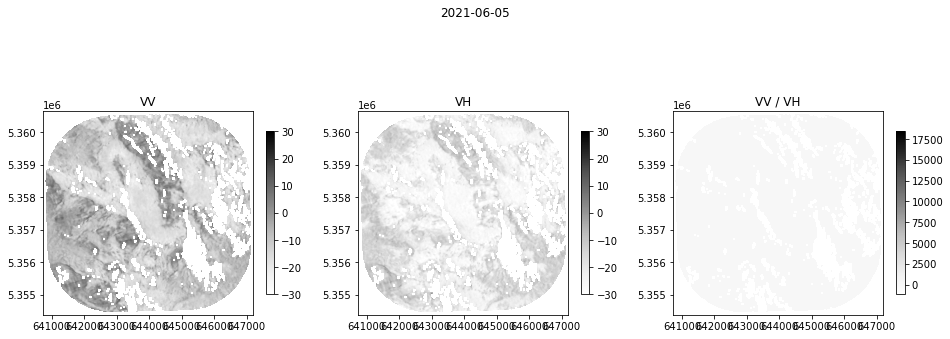

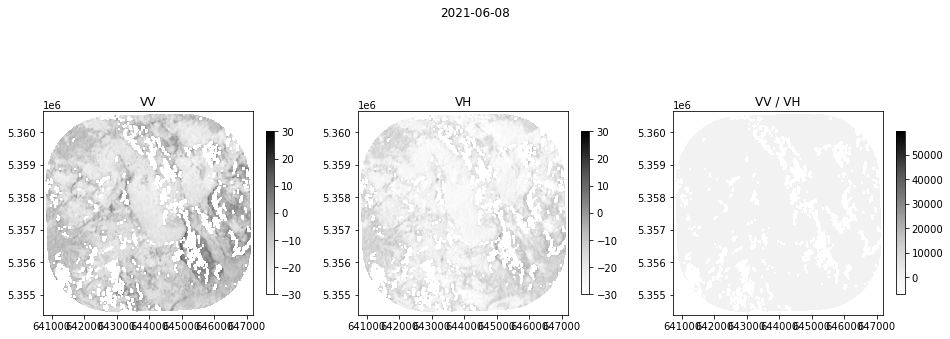

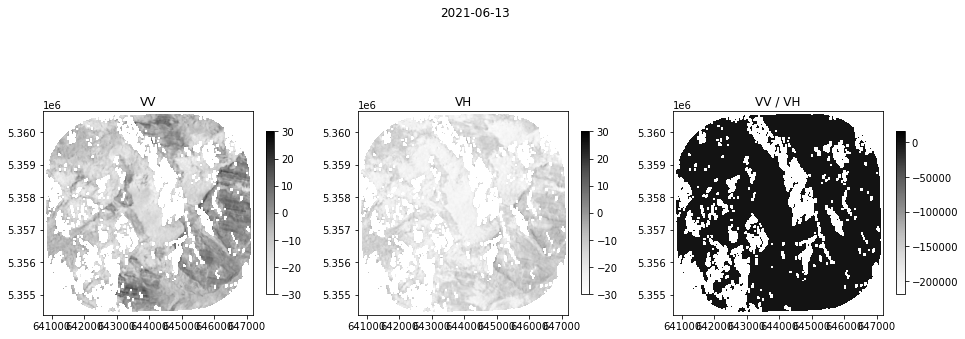

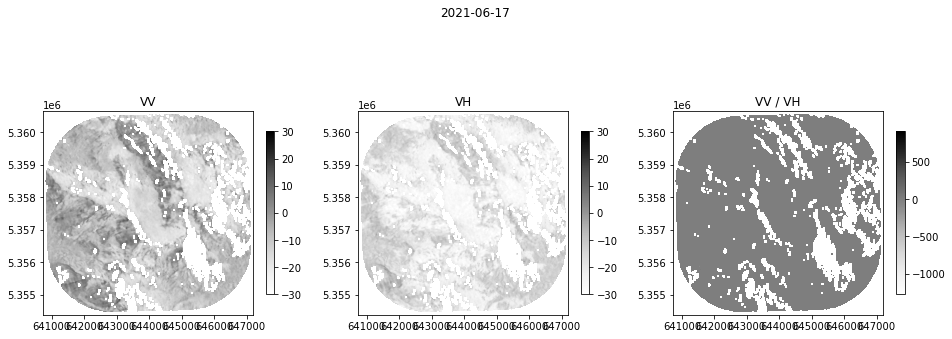

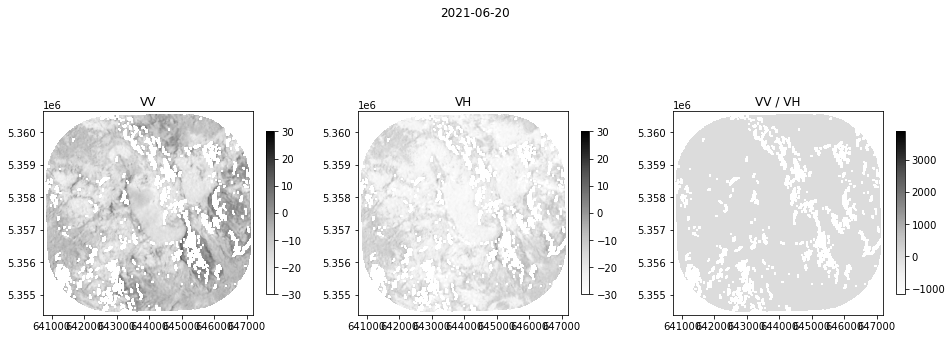

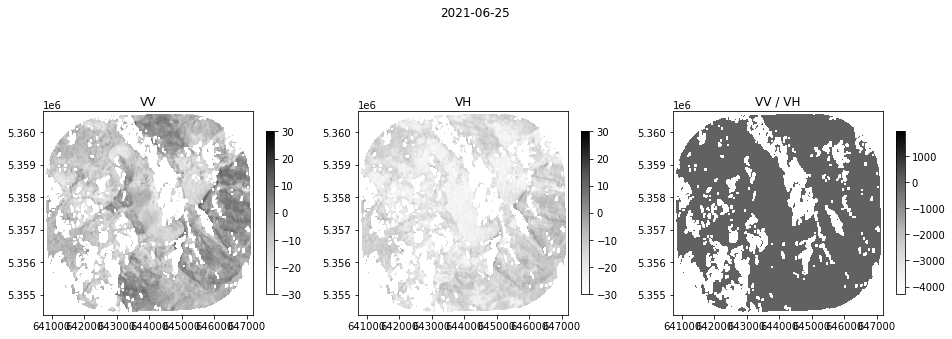

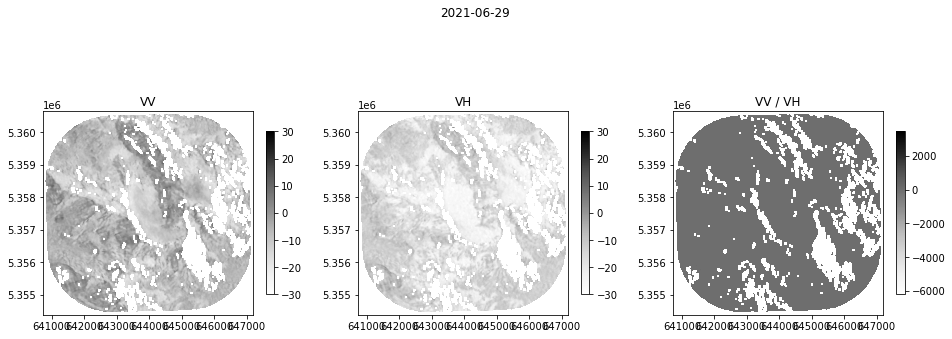

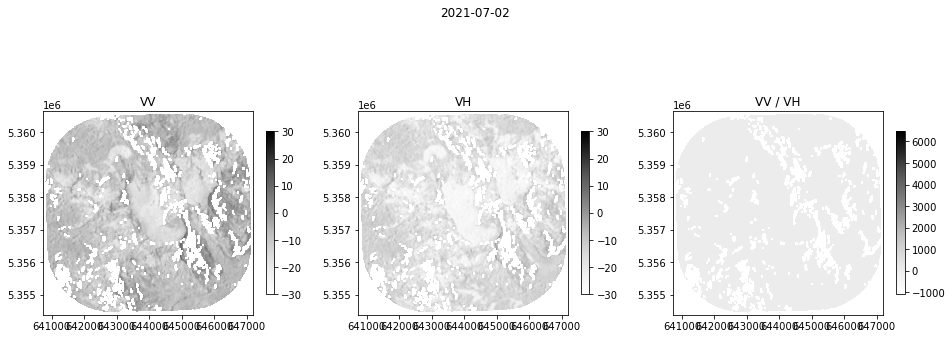

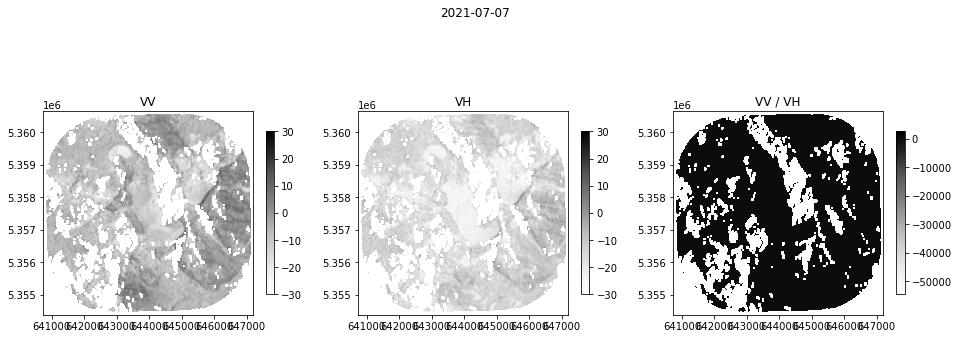

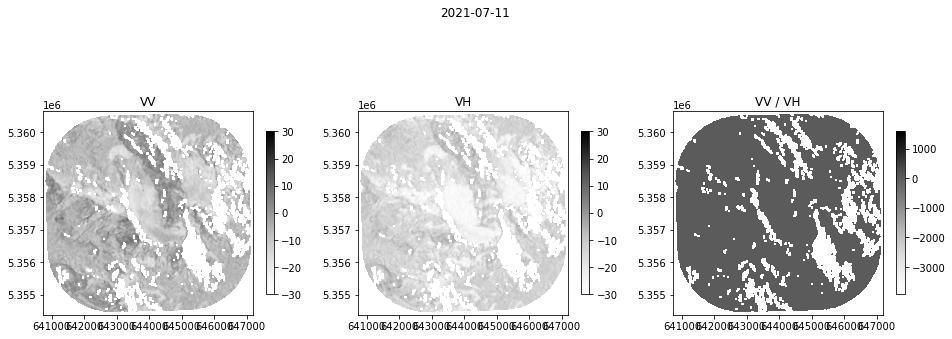

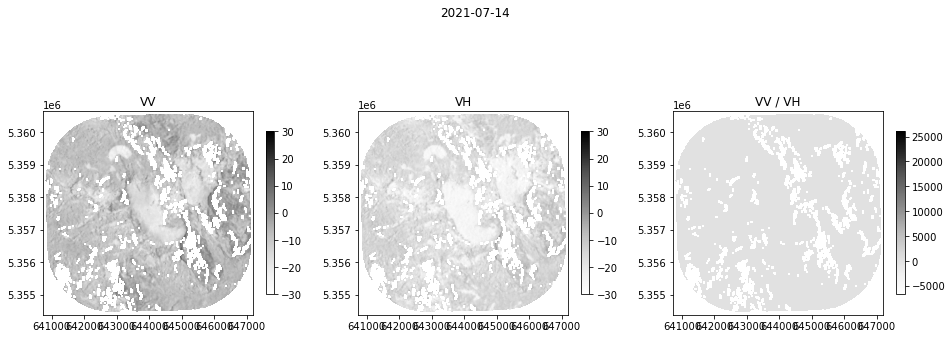

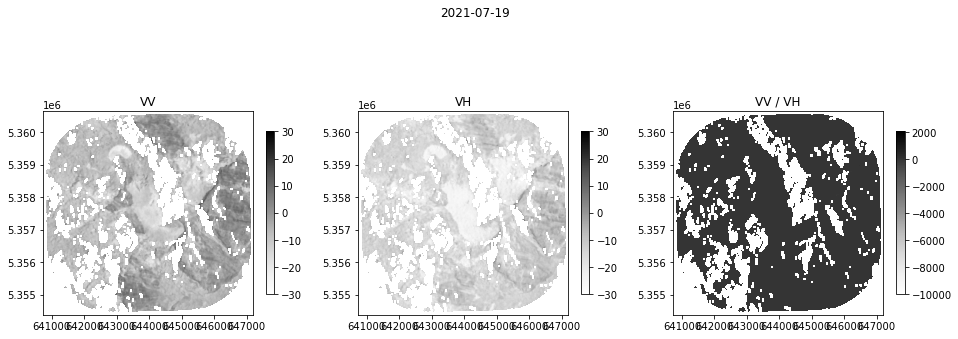

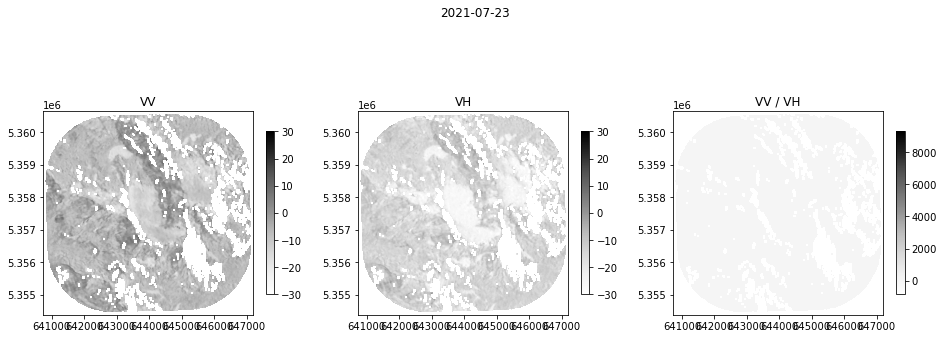

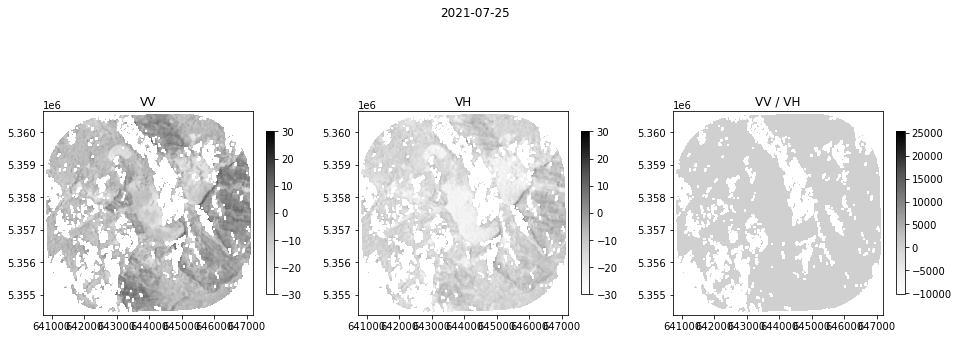

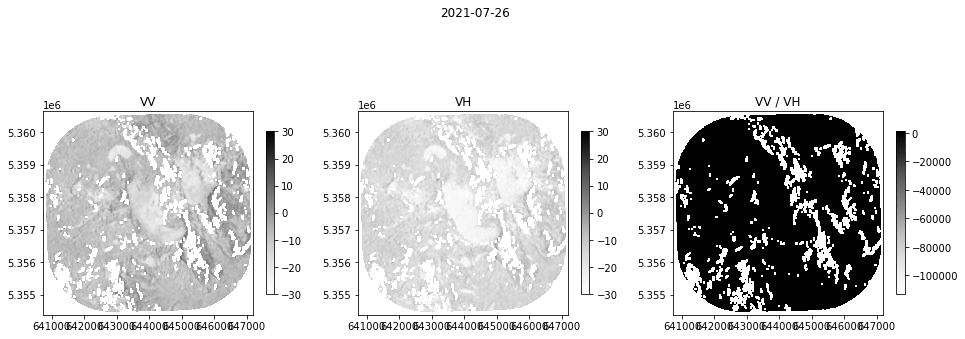

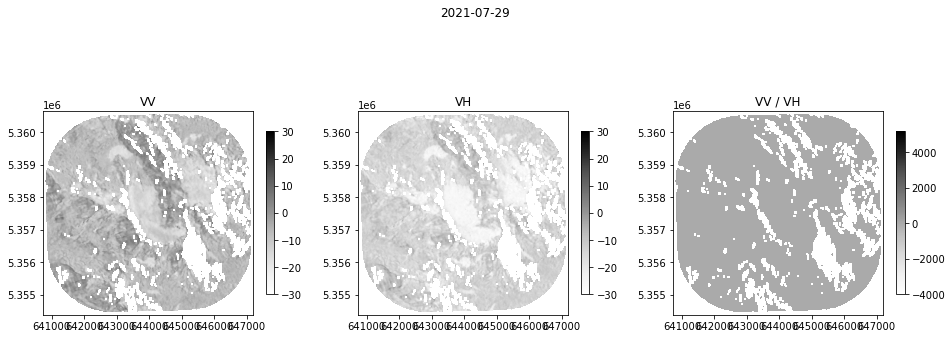

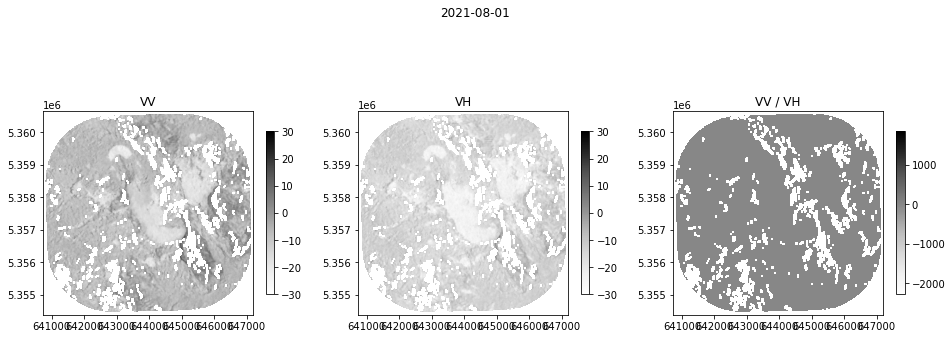

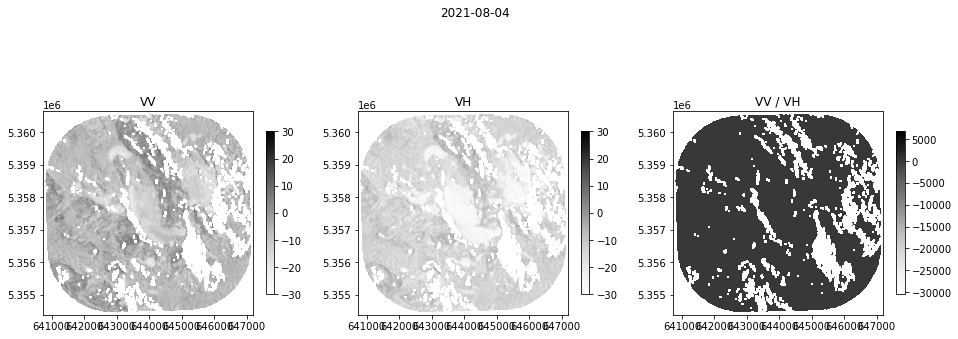

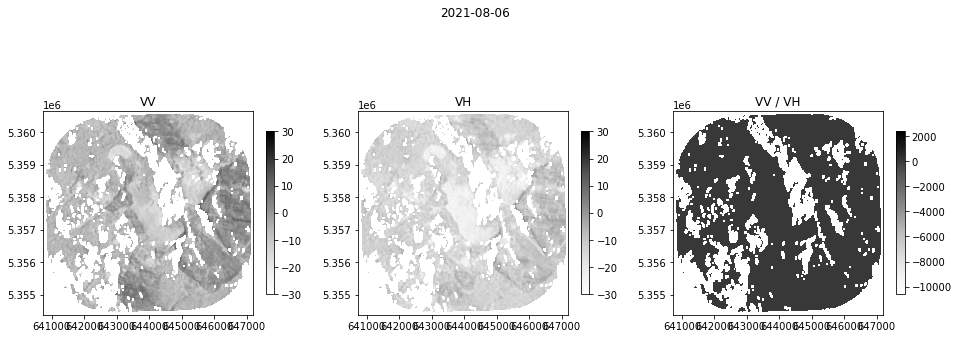

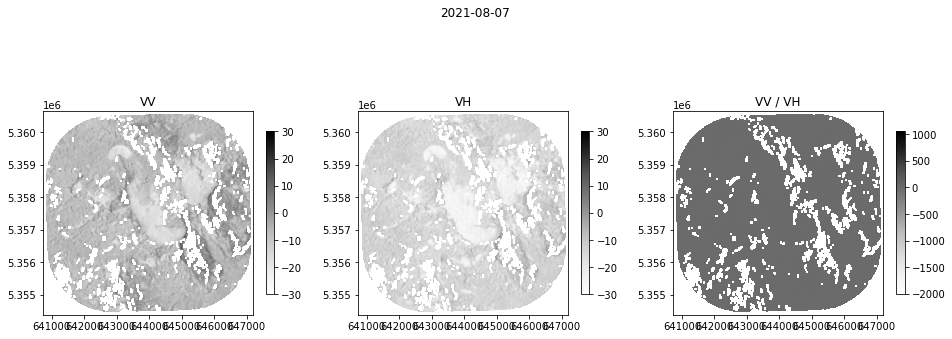

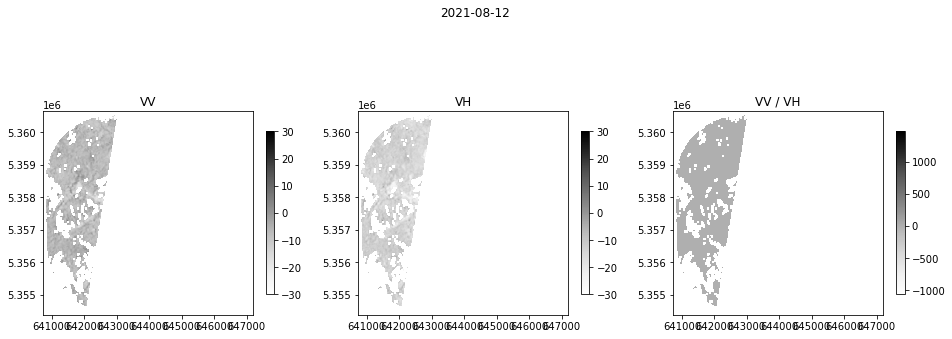

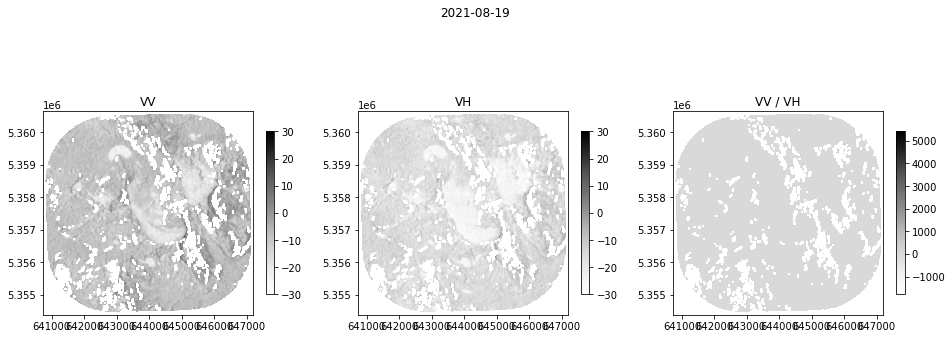

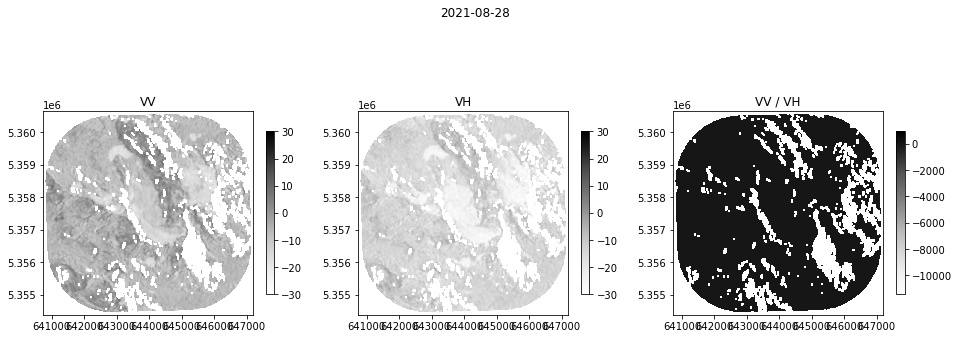

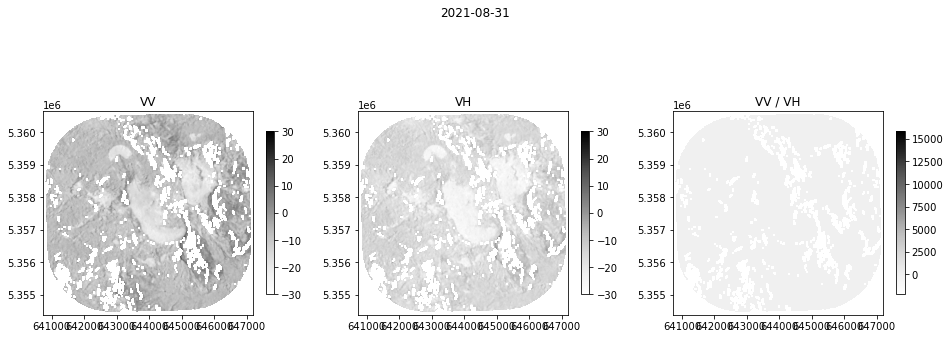

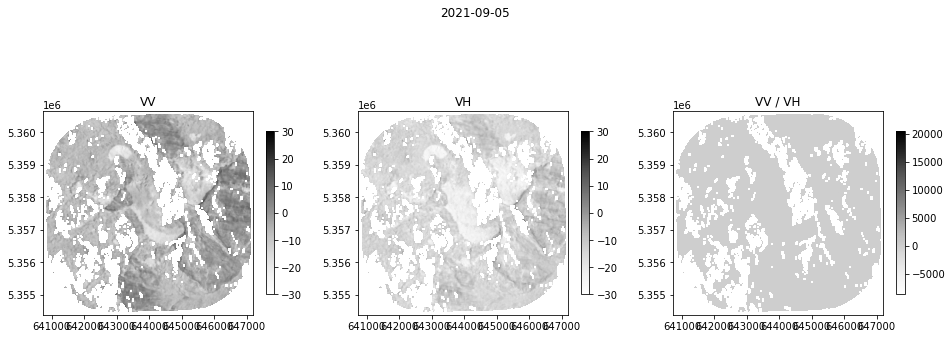

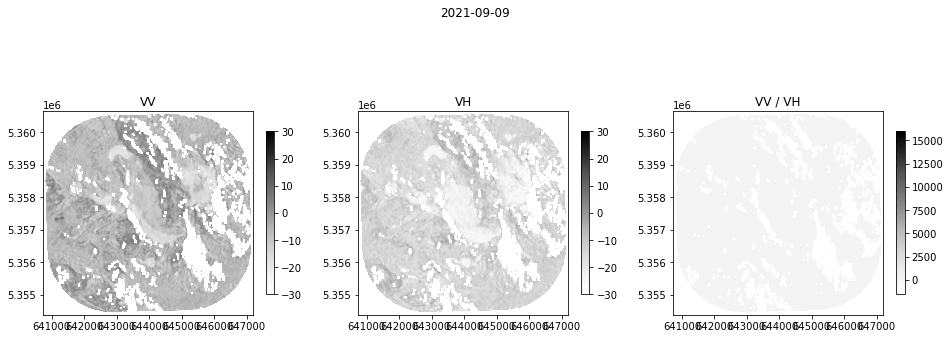

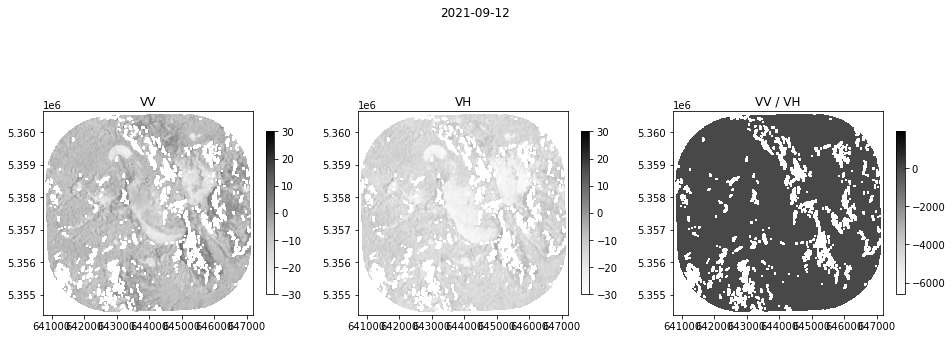

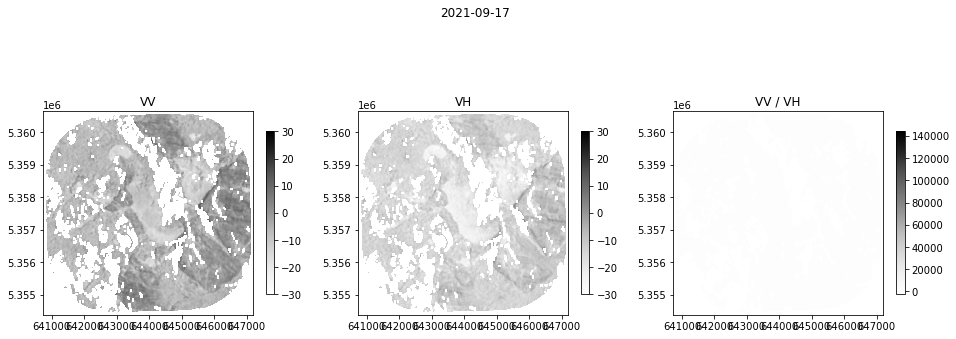

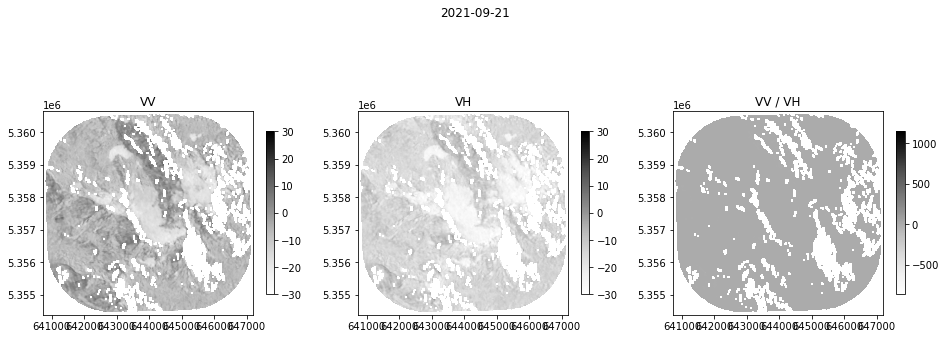

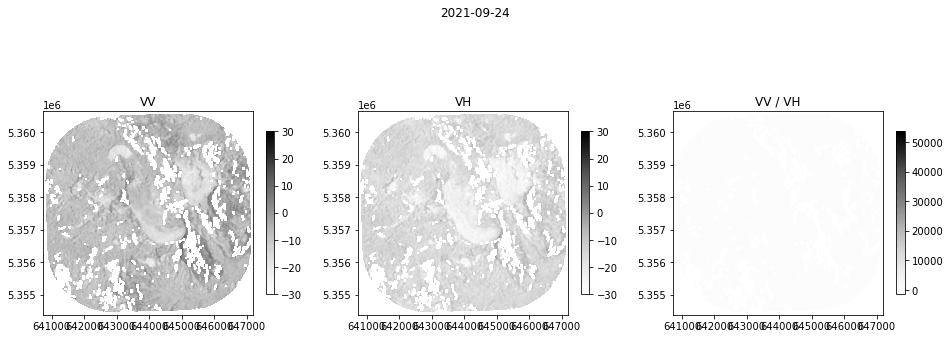

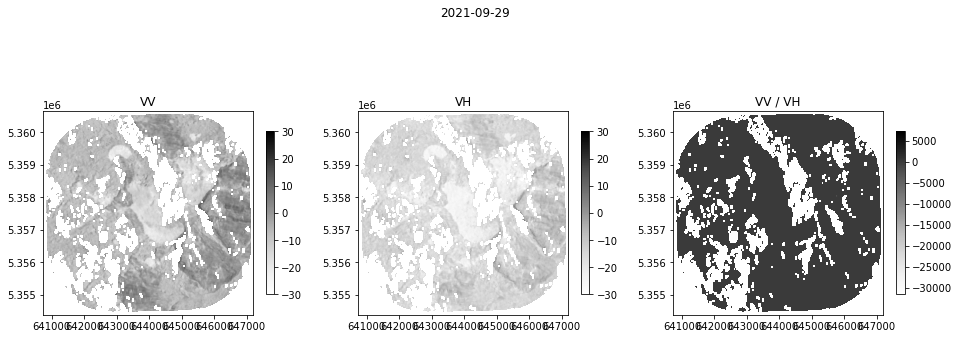

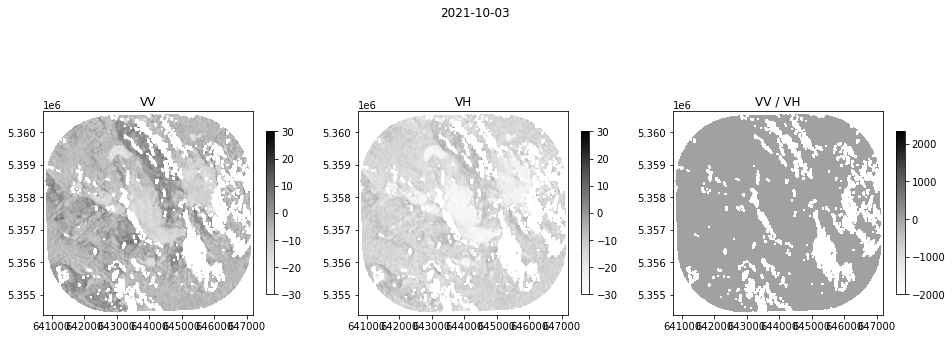

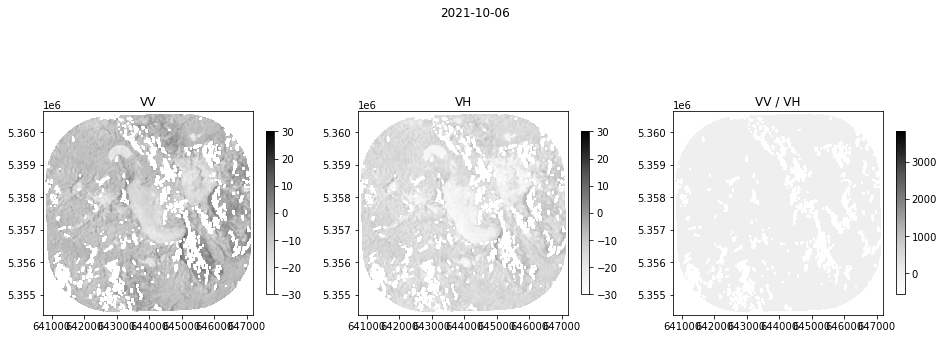

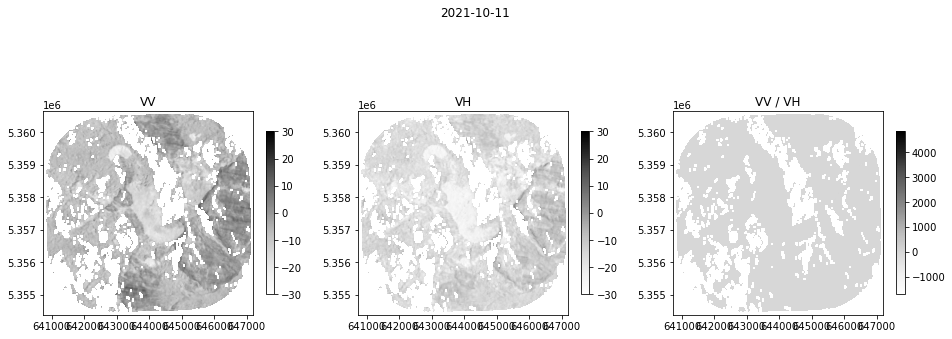

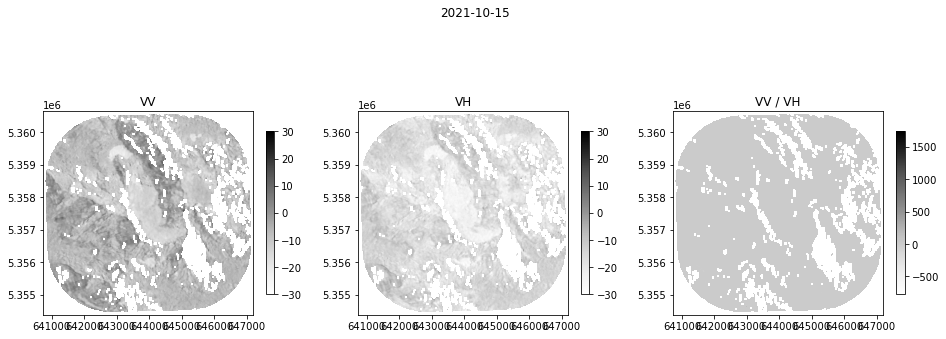

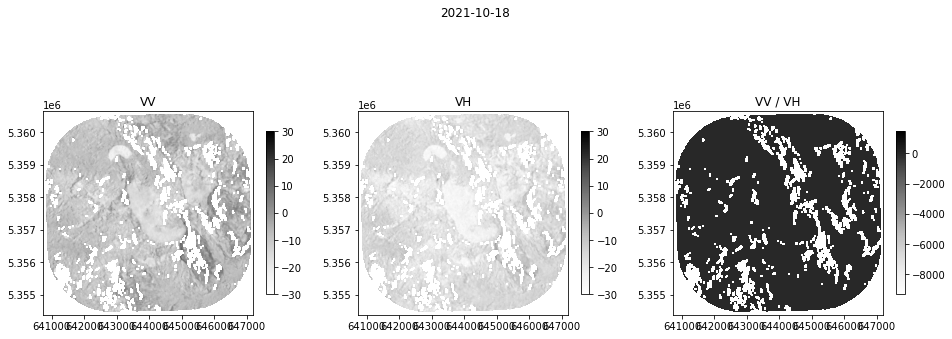

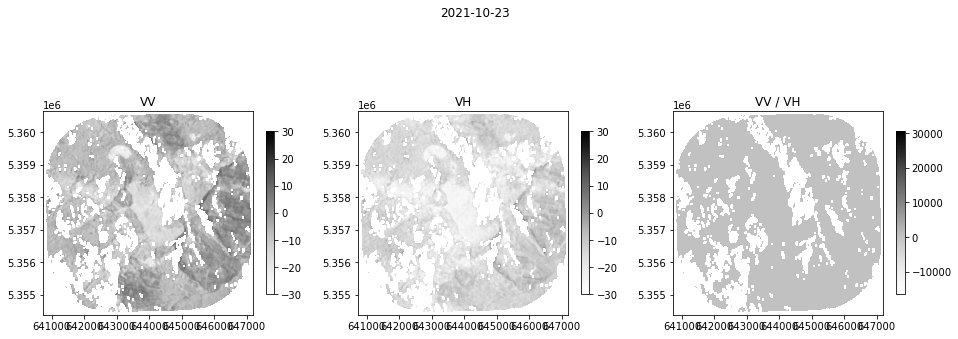

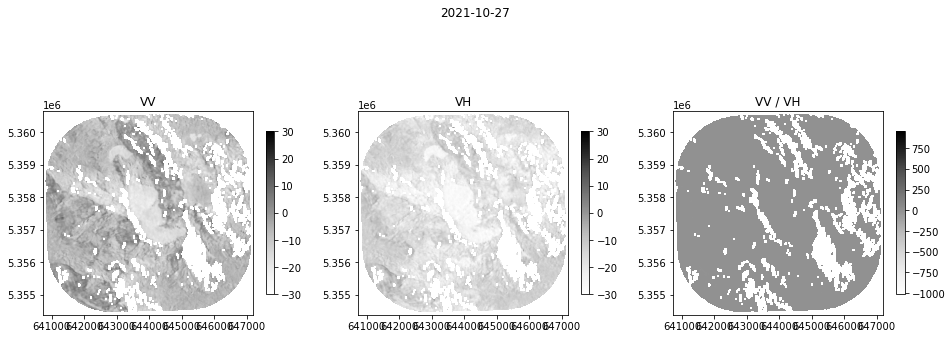

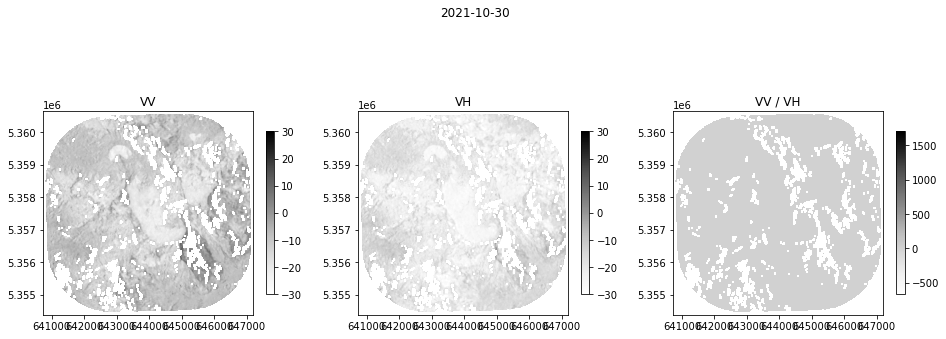

In [7]:
for t in S1_ds.time:
    
    im = S1_ds.sel(time=t)
    
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    vv_im = ax[0].imshow(im['VV'].data, cmap='Greys', clim=(-30,30),
                 extent=(np.min(im.x.data), np.max(im.x.data), 
                         np.min(im.y.data), np.max(im.y.data)))
    ax[0].set_title('VV')
    vh_im = ax[1].imshow(im['VH'].data, cmap='Greys', clim=(-30,30),
                 extent=(np.min(im.x.data), np.max(im.x.data), 
                         np.min(im.y.data), np.max(im.y.data)))  
    ax[1].set_title('VH')
    vvvh_im = ax[2].imshow(im['VV'].data / im['VH'].data, cmap='Greys',
                 extent=(np.min(im.x.data), np.max(im.x.data), 
                         np.min(im.y.data), np.max(im.y.data)))
    ax[2].set_title('VV / VH')
    fig.colorbar(vv_im, ax=ax[0], shrink=0.5)
    fig.colorbar(vh_im, ax=ax[1], shrink=0.5)
    fig.colorbar(vvvh_im, ax=ax[2], shrink=0.5)
    fig.suptitle(str(t.data)[0:10])
    plt.show()

In [8]:
S1_ds.time

<xarray.DataArray 'time' (time: 47)>
array(['2021-05-03T14:12:33.000000000', '2021-05-08T14:20:49.000000000',
       '2021-05-12T01:53:29.000000000', '2021-05-15T14:12:33.000000000',
       '2021-05-20T14:20:49.000000000', '2021-05-24T01:53:30.000000000',
       '2021-05-27T14:12:34.000000000', '2021-06-01T14:20:50.000000000',
       '2021-06-05T01:53:30.000000000', '2021-06-08T14:12:35.000000000',
       '2021-06-13T14:20:51.000000000', '2021-06-17T01:53:31.000000000',
       '2021-06-20T14:12:35.000000000', '2021-06-25T14:20:52.000000000',
       '2021-06-29T01:53:32.000000000', '2021-07-02T14:12:36.000000000',
       '2021-07-07T14:20:52.000000000', '2021-07-11T01:53:32.000000000',
       '2021-07-14T14:12:37.000000000', '2021-07-19T14:20:53.000000000',
       '2021-07-23T01:53:33.000000000', '2021-07-25T14:21:32.000000000',
       '2021-07-26T14:12:38.000000000', '2021-07-29T01:54:23.000000000',
       '2021-08-01T14:13:11.000000000', '2021-08-04T01:53:34.000000000',
       '2021-08-06T14:21:33.000000000', '2021-08-07T14:12:38.000000000',
       '2021-08-12T14:20:54.000000000', '2021-08-19T14:12:39.000000000',
       '2021-08-28T01:53:35.000000000', '2021-08-31T14:12:39.000000000',
       '2021-09-05T14:20:56.000000000', '2021-09-09T01:53:36.000000000',
       '2021-09-12T14:12:40.000000000', '2021-09-17T14:20:56.000000000',
       '2021-09-21T01:53:36.000000000', '2021-09-24T14:12:40.000000000',
       '2021-09-29T14:20:56.000000000', '2021-10-03T01:53:37.000000000',
       '2021-10-06T14:12:40.000000000', '2021-10-11T14:20:57.000000000',
       '2021-10-15T01:53:37.000000000', '2021-10-18T14:12:41.000000000',
       '2021-10-23T14:20:57.000000000', '2021-10-27T01:53:37.000000000',
       '2021-10-30T14:12:41.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-05-03T14:12:33 ... 2021-10-30T14:...
    spatial_ref  int64 0